In [9]:
from google.colab import drive
drive.mount('/content/drive')
# Importing important libraries
import tensorflow as tf
import os
import glob
import time
import zipfile
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import img_to_array, load_img

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Extract dataset
zip_path = '/content/drive/MyDrive/summer2winter.zip'
extract_path = '/content/dataset'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Load and preprocess images
def load_image(file_path):
    image = img_to_array(load_img(file_path))
    image = tf.image.resize(image, [256, 256])
    return (image / 127.5) - 1.0

def load_dataset(directory):
    files = glob.glob(os.path.join(directory, '*'))
    return tf.data.Dataset.from_tensor_slices(files).map(lambda x: tf.numpy_function(load_image, [x], tf.float32)).batch(1)

# Load datasets
train_A = load_dataset(os.path.join(extract_path, 'trainA'))
train_B = load_dataset(os.path.join(extract_path, 'trainB'))
test_A = load_dataset(os.path.join(extract_path, 'testA'))
test_B = load_dataset(os.path.join(extract_path, 'testB'))



In [11]:
# Define the generator model
def build_generator():
    inputs = layers.Input(shape=[256, 256, 3])  # Define input layer with shape 256x256x3 (RGB image)

    # Define down-sampling layers (encoder)
    down_sample = [
        layers.Conv2D(64, 4, strides=2, padding='same', use_bias=False),  # Convolutional layer with 64 filters, 4x4 kernel, stride 2
        layers.BatchNormalization(),  # Batch normalization for stabilizing training
        layers.LeakyReLU(),  # LeakyReLU activation function
        layers.Conv2D(128, 4, strides=2, padding='same', use_bias=False),  # Convolutional layer with 128 filters
        layers.BatchNormalization(),  # Batch normalization
        layers.LeakyReLU(),  # LeakyReLU activation function
        layers.Conv2D(256, 4, strides=2, padding='same', use_bias=False),  # Convolutional layer with 256 filters
        layers.BatchNormalization(),  # Batch normalization
        layers.LeakyReLU(),  # LeakyReLU activation function
        layers.Conv2D(512, 4, strides=2, padding='same', use_bias=False),  # Convolutional layer with 512 filters
        layers.BatchNormalization(),  # Batch normalization
        layers.LeakyReLU()  # LeakyReLU activation function
    ]

    # Define up-sampling layers (decoder)
    up_sample = [
        layers.Conv2DTranspose(256, 4, strides=2, padding='same', use_bias=False),  # Transposed convolution with 256 filters
        layers.BatchNormalization(),  # Batch normalization
        layers.ReLU(),  # ReLU activation function
        layers.Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False),  # Transposed convolution with 128 filters
        layers.BatchNormalization(),  # Batch normalization
        layers.ReLU(),  # ReLU activation function
        layers.Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False),  # Transposed convolution with 64 filters
        layers.BatchNormalization(),  # Batch normalization
        layers.ReLU()  # ReLU activation function
    ]

    # Final layer to get the output image
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02), activation='tanh')  # Transposed convolution with 3 filters and tanh activation for output image

    x = inputs  # Initialize x with input layer
    for d in down_sample: x = d(x)  # Apply down-sampling layers
    for u in up_sample: x = u(x)  # Apply up-sampling layers
    x = last(x)  # Apply final layer
    return tf.keras.Model(inputs=inputs, outputs=x)  # Return the model


In [12]:
# Define the discriminator model
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)  # Initialize weights with a normal distribution

    i = layers.Input(shape=[256, 256, 3], name='input_image')  # Input layer for the input image
    t = layers.Input(shape=[256, 256, 3], name='target_image')  # Input layer for the target image
    x = layers.concatenate([i, t])  # Concatenate input and target images along the channel dimension

    # Define down-sampling layers
    down_stack = [
        layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False),  # Convolutional layer with 64 filters
        layers.LeakyReLU(),  # LeakyReLU activation function
        layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False),  # Convolutional layer with 128 filters
        layers.BatchNormalization(),  # Batch normalization
        layers.LeakyReLU(),  # LeakyReLU activation function
        layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False),  # Convolutional layer with 256 filters
        layers.BatchNormalization(),  # Batch normalization
        layers.LeakyReLU()  # LeakyReLU activation function
    ]

    x = layers.ZeroPadding2D()(x)  # Zero padding to maintain spatial dimensions
    x = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(x)  # Convolutional layer with 512 filters
    x = layers.BatchNormalization()(x)  # Batch normalization
    x = layers.LeakyReLU()(x)  # LeakyReLU activation function
    x = layers.ZeroPadding2D()(x)  # Additional zero padding
    x = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x)  # Output layer with a single filter to produce a single output

    return tf.keras.Model(inputs=[i, t], outputs=x)  # Return the discriminator model


In [13]:
# Instantiate models
Gen_AB = build_generator()
Gen_BA = build_generator()
Dis_A = build_discriminator()
Dis_B = build_discriminator()

In [14]:
# Define loss functions
lo = tf.keras.losses.BinaryCrossentropy(from_logits=True)  # Binary cross-entropy loss function, expecting logits

def discriminator_loss(real, generated):
    real_loss = lo(tf.ones_like(real), real)  # Loss for real images (target is all ones)
    generated_loss = lo(tf.zeros_like(generated), generated)  # Loss for generated (fake) images (target is all zeros)
    return 0.5 * (real_loss + generated_loss)  # Average the losses

def generator_loss(generated):
    return lo(tf.ones_like(generated), generated)  # Loss for generated images (target is all ones)

def calc_cycle_loss(real_image, cycled_image, lambda_cycle=10):
    return lambda_cycle * tf.reduce_mean(tf.abs(real_image - cycled_image))  # Cycle consistency loss with a scaling factor

def identity_loss(real_image, same_image, lambda_identity=5):
    return lambda_identity * tf.reduce_mean(tf.abs(real_image - same_image))  # Identity loss with a scaling factor


In [15]:
# Define optimizers
gen_G_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)  # Adam optimizer for generator G with learning rate 0.0002 and beta_1=0.5
gen_F_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)  # Adam optimizer for generator F with same parameters
dis_X_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)  # Adam optimizer for discriminator X with same parameters
dis_Y_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)  # Adam optimizer for discriminator Y with same parameters


In [16]:
# Training step function
@tf.function  # This decorator compiles the function for faster execution
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:  # GradientTape records operations for automatic differentiation
        # Generate fake images
        fake_y = Gen_AB(real_x, training=True)  # Generate fake Y from real X
        cycled_x = Gen_BA(fake_y, training=True)  # Cycle back to X from fake Y
        fake_x = Gen_BA(real_y, training=True)  # Generate fake X from real Y
        cycled_y = Gen_AB(fake_x, training=True)  # Cycle back to Y from fake X
        same_x = Gen_BA(real_x, training=True)  # Generate same X from real X (identity mapping)
        same_y = Gen_AB(real_y, training=True)  # Generate same Y from real Y (identity mapping)

        # Discriminator predictions
        disc_real_x = Dis_A([real_x, real_y], training=True)  # Discriminator Dis_A on real X and real Y
        disc_real_y = Dis_B([real_y, real_x], training=True)  # Discriminator Dis_B on real Y and real X
        disc_fake_x = Dis_A([fake_x, real_y], training=True)  # Discriminator Dis_A on fake X and real Y
        disc_fake_y = Dis_B([fake_y, real_x], training=True)  # Discriminator Dis_B on fake Y and real X

        # Generator losses
        gen_G_loss = generator_loss(disc_fake_y)  # Loss for generator Gen_AB
        gen_F_loss = generator_loss(disc_fake_x)  # Loss for generator Gen_BA
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)  # Total cycle consistency loss
        total_gen_G_loss = gen_G_loss + total_cycle_loss + identity_loss(real_y, same_y)  # Total loss for generator Gen_AB
        total_gen_F_loss = gen_F_loss + total_cycle_loss + identity_loss(real_x, same_x)  # Total loss for generator Gen_BA

        # Discriminator losses
        disc_X_loss = discriminator_loss(disc_real_x, disc_fake_x)  # Loss for discriminator Dis_A
        disc_Y_loss = discriminator_loss(disc_real_y, disc_fake_y)  # Loss for discriminator Dis_B

    # Calculate gradients
    gradients_G = tape.gradient(total_gen_G_loss, Gen_AB.trainable_variables)  # Gradients for generator Gen_AB
    gradients_F = tape.gradient(total_gen_F_loss, Gen_BA.trainable_variables)  # Gradients for generator Gen_BA
    gradients_D_A = tape.gradient(disc_X_loss, Dis_A.trainable_variables)  # Gradients for discriminator Dis_A
    gradients_D_B = tape.gradient(disc_Y_loss, Dis_B.trainable_variables)  # Gradients for discriminator Dis_B

    # Apply gradients
    gen_G_opt.apply_gradients(zip(gradients_G, Gen_AB.trainable_variables))  # Apply gradients to Gen_AB
    gen_F_opt.apply_gradients(zip(gradients_F, Gen_BA.trainable_variables))  # Apply gradients to Gen_BA
    dis_X_opt.apply_gradients(zip(gradients_D_A, Dis_A.trainable_variables))  # Apply gradients to Dis_A
    dis_Y_opt.apply_gradients(zip(gradients_D_B, Dis_B.trainable_variables))  # Apply gradients to Dis_B


In [ ]:
# Training loop
num_epochs = 1  # Number of epochs for training, adjust as needed
save_interval = 1  # Interval for saving models

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time

    # Zip datasets together for simultaneous iteration
    dataset = tf.data.Dataset.zip((train_A, train_B))

    # Iterate over the zipped dataset
    for real_x, real_y in dataset:
        train_step(real_x, real_y)  # Perform a training step

    end_time = time.time()  # Record end time
    print(f"Epoch [{epoch+1}/{num_epochs}] completed in {end_time - start_time:.2f}s")  # Print epoch duration

    # Save models at specified intervals
    if (epoch + 1) % save_interval == 0:
        for model, name in zip([Gen_AB, Gen_BA, Dis_A, Dis_B], ['Gen_AB', 'Gen_BA', 'Dis_A', 'Dis_B']):
            model.save(f'{name}_epoch_{epoch+1}.h5')  # Save the model
        print(f"Models saved at epoch {epoch+1}")  # Confirm models saved


In [34]:
# Load and preprocess a sample image
def load_and_preprocess_image(image_path):
    image = img_to_array(load_img(image_path))
    image = tf.image.resize(image, [256, 256])
    return tf.expand_dims((image / 127.5) - 1.0, 0)

# Plot images
def plot_images(original, transformed, title):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    for ax, img, title in zip(axs, [original, transformed], ['Original Image', title]):
        ax.imshow((img[0] * 0.5) + 0.5)
        ax.set_title(title)
        ax.axis('off')
    plt.show()

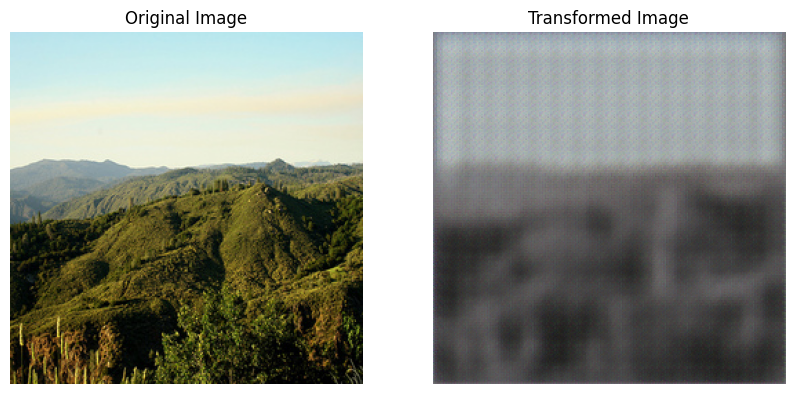

In [35]:
# Load and transform a sample image
test_image_path = '/content/dataset/testA/2011-06-26 19_33_40.jpg'
test_image = load_and_preprocess_image(test_image_path)

# Apply the transformation
transformed_image = Gen_AB(test_image, training=False)

# Plot the original and transformed images
plot_images(test_image, transformed_image, 'Transformed Image')

In [36]:
# It is taking very much time for even a single epoch. But for the more time I keep running the training loop, better and more clear the transformmed image gets. You can see above.